In [577]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import seaborn as sns


In [578]:
from scipy.stats import norm#will need to import this to run
import operator

#NOTE: all days are calculated as trading days, so 252 per year
class stocks:
#     market = Market()
    def __init__(self, start_prx = 100, an_vol = 0.20**2, an_ret = 0.08, dist = norm, cor = 0.5):
        #assumes normal distribution
        self.start_prx = start_prx
        self.an_vol = an_vol
        self.an_ret = an_ret
        #below might not be true for all dists.
        #WARNING Average VOl, RETs higher than expected due to Jensens.!
        self.ret_dist = dist(loc = an_ret/252, scale = (an_vol/252)**0.5)#distribution from which returns are drawn
#         self.val_dist, don't know how to include path dependance
        #currently unused
        self.q_div = 0#quarterly dividend
        self.history = np.empty(1)
        self.cor = cor
        
    def inc_time(self, n = 252, reps = 1):
        "return array of historical performance, each row a potential run of same stock"
        daily_rets = self.ret_dist.rvs(size = reps * n).reshape(reps, n)
        daily_position = np.exp(np.cumsum(daily_rets, axis = 1)) * self.start_prx
        return daily_position


class options:
    valid_op_types = ["euro_call", "euro_put"]#always lowercase

    def __init__(self, underlying = stocks(), interest_rates = 0.02, strike = None, days_to_exp = 252, op_type = "euro_call"):
        self.underlying = underlying
        self.interest_rates = interest_rates#assumed to be the natural, riskfree rate
        self.strike = strike or self.underlying.start_prx
        self.days_to_exp = days_to_exp
        self.op_type = op_type
        
    op_type = property(operator.attrgetter('_op_type'))
    @op_type.setter
    def op_type(self, o):
        if not o in options.valid_op_types: 
            o = o.lower()
            if not o in options.valid_op_types: raise Exception(f"Invalid Opition type {o}, must be {options.valid_op_types}")
        self._op_type = o
    
    def check_if_euro(self):
          if self.op_type[:4] != "euro":
            print(f"\n\n\n WARNING: Using BS on a None-European Option ({self.op_type}), Results will be approximate \n\n\n")
            
    def bs_value(self):
        "assumes that T is in years; an issue?"
        self.check_if_euro()
        d1 = 1/np.sqrt(self.underlying.an_vol * self.days_to_exp/252) *\
        (np.log(self.underlying.start_prx / self.strike) + (self.underlying.an_ret + self.underlying.an_vol/2)*(self.days_to_exp/252))
        d2 = d1 - (self.underlying.an_vol * self.days_to_exp/252)**0.5
        #d2 = d1 - (self.underlying.an_vol**0.5) * np.sqrt(self.days_to_exp/252)        
        pv_k = self.strike * np.exp(-self.interest_rates * self.days_to_exp / 252)
        call_val = norm.cdf(d1)*self.underlying.start_prx - norm.cdf(d2)*pv_k
        print(d1, d2, pv_k, call_val)
        if self.op_type[-4:] == "call":
            return call_val
        elif self.op_type[-3:] == "put":
            return pv_k - self.underlying.start_rpx + call_val
    
    def bs_value_by_greek(self, spot_prx = None, exp_interest_rates = None, exp_vol = None, progress_days = True, intervals = None, ret = "value"):
        #in future should account for changing spot prices to shift the exp volatility
        if progress_days:
            time =  np.flip(np.arange(0, self.days_to_exp/252, 1/252))#time is converted to year fragments
            intervals = self.days_to_exp
        else:        
            intervals = intervals or self.days_to_exp
            time = np.repeat(self.days_to_exp, intervals)
        #in future use **kwargs, use get on dict and set default?
        if spot_prx is None:
            spot_prx = np.repeat(self.underlying.start_prx, intervals)
        if exp_interest_rates is None:
            exp_interest_rates = np.repeat(self.interest_rates, intervals)
        if exp_vol is None:
            exp_vol = np.repeat(self.underlying.an_vol, intervals)
        self.check_if_euro()
        
        pv_k = self.strike * np.exp(-1*exp_interest_rates * time)#present value of strike price
        d1 = 1/np.sqrt(exp_vol * time) * (np.log(spot_prx/self.strike) + (exp_interest_rates  + exp_vol/2)*time)
        #"N(d1) measure of Moneyness" in SD; value of an asset or nothing call [issue w/ correlation between prx and ITM]
        d2 = d1 - np.sqrt(exp_vol * time)
        #N(d2) isprob of expiring ITM, %moneyness; prob of all or nothing call. Prob call excised
        #valuing diff types
        if self.op_type[-4:] == "call":
            value = norm.cdf(d1)*spot_prx - norm.cdf(d2)*pv_k
        elif self.op_type[-3:] == "put":
            value = norm.cdf(-1*d2)*pv_k - norm.cdf(-d1)*spot_prx
        else:
            raise Exception(f"Invalid type: {self.op_type}")
            
        if type(ret) is str:
            return eval(ret)
        else:
#             return [eval(i) for i in ret]#works occasionally? Why?
            l = locals()#can't use eval because for some reason that only evals to param names of the function space from which it was called
            return [l[i] for i in ret]
            
    def calc_greek(*argv):
        for arg in argv:
            if arg == "delta":
                return 

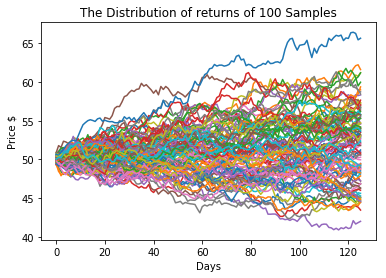

c:\users\clark benham\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide


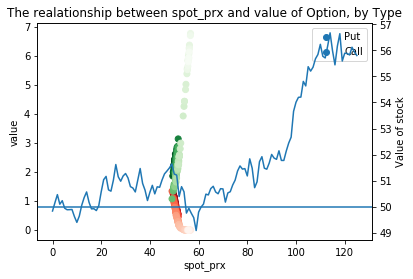

c:\users\clark benham\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in multiply


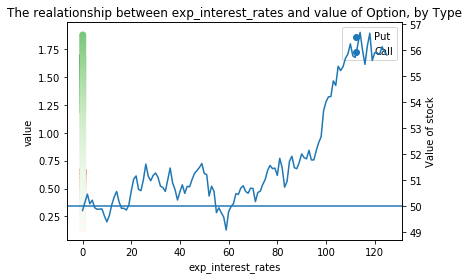

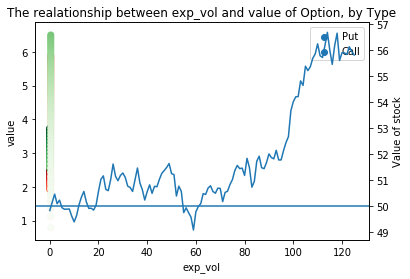

In [600]:
# s = stocks()
s = stocks(start_prx = 50, an_ret = 0.05, an_vol = 0.12**2)
n = 126
reps = 100
hist = s.inc_time(n = n, reps = reps)
# print(np.mean(hist, axis = 1), np.std(hist, axis = 1))
for i in range(reps):
    plt.plot(range(n), hist[i])
plt.title(f"The Distribution of returns of {reps} Samples")
plt.xlabel("Days")
plt.ylabel("Price $")
plt.show()
# print(opt_call.bs_value())

def two_greeks_pc(g1, g2, optp, optc, hist):
    "Gets darker as time progesses"
    fig, ax1 = plt.subplots()
    px, py, time = optp#opt_put.bs_value_by_greek(spot_prx = hist, ret= [g1,g2, "time"])
    callx, cally = optc#opt_call.bs_value_by_greek(spot_prx = hist, ret= [g1, g2])
    ax1.scatter(px, py, label = "Put", c = time, cmap = "Reds")
    ax1.scatter(callx, cally, label = "Call", c= time, cmap = "Greens")#, c =opt_call.bs_value_by_greek(ret= ["time"]))
    plt.title(f"The realationship between {g1} and {g2} of Option, by Type")
    plt.xlabel(g1)
    plt.ylabel(g2)
    ax1.legend()
    
    ax2 = ax1.twinx()
    ax2.plot(hist)#, c = time, cmap = "Greys")
    ax2.set_ylabel(f"Value of stock")
    ax2.axhline(strk)
    plt.show()
    
    
strk = 50
opt_call = options(s, interest_rates = 0.05, strike = strk, days_to_exp = 126, op_type = "euro_call")
opt_put = options(s, interest_rates = 0.05, strike = strk, days_to_exp = 126, op_type = "euro_put")
    
g1,g2 = ("spot_prx", "value")
optp = opt_put.bs_value_by_greek(spot_prx = hist[0], ret= [g1,g2, "time"])
optc = opt_call.bs_value_by_greek(spot_prx = hist[0], ret= [g1, g2])
two_greeks_pc("spot_prx", "value", optp, optc, hist[0])

g1,g2 = ("exp_interest_rates", "value")
optp = opt_put.bs_value_by_greek(exp_interest_rates= np.concatenate((np.repeat(0, n//2),np.repeat(0.1, n//2))), ret= [g1,g2, "time"])
optc = opt_call.bs_value_by_greek(exp_interest_rates= np.concatenate((np.repeat(0, n//2),np.repeat(0.1, n//2))), ret= [g1, g2])
two_greeks_pc("exp_interest_rates", "value", optp, optc, hist[0])

g1, g2 = ("exp_vol", "value")
optp = opt_put.bs_value_by_greek(exp_vol= np.concatenate((np.repeat(0.05, n//2),np.repeat(0.4, n//2))), ret= [g1,g2, "time"])
optc = opt_call.bs_value_by_greek(exp_vol= np.concatenate((np.repeat(0.05, n//2),np.repeat(0.4, n//2))), ret= [g1, g2])
two_greeks_pc("exp_vol", "value", optp, optc, hist[0])
# two_greeks_pc("spot_prx", "value", hist[0])
# plt.title("The realationship between Spot Prices and Value of Put Option")


In [ ]:
def two_greeks_pc(g1, g2):
    fig, ax1 = ax1.subplots()
    ax1.scatter(*opt_put.bs_value_by_greek(spot_prx = hist[0], ret= [g1,g2]), label = "Put")
    ax1.title(f"The realationship between {g1} and {g2} of Option, by Type")
    ax1.scatter(*opt_call.bs_value_by_greek(ret= [g1, g2]), label = "Call")#, c =opt_call.bs_value_by_greek(ret= ["time"]))
    ax1.xlabel(g1)
    ax1.ylabel(g2)
    ax1.legend()
    ax1.show()
